In [1]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecMonitor, VecFrameStack, DummyVecEnv

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import torch


import sys
sys.path.append('../') #This is added so we can import from the source folder
from src.policies import ImpalaCNN

def make_procgen_env(env_name, num_envs=1, start_level=0, num_levels=0):
    def _init():
        
        return env
    return DummyVecEnv([_init] * num_envs)

env_name = "procgen:procgen-heist-v0"  



env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 



In [72]:
def load_model(model_path = '../model_1400_latest.pt'):
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model


In [51]:
@torch.no_grad()
def generate_action(model, observation):
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

    model_output = model(observation)
    
    logits = model_output[0].logits  # discard the output of the critic in our actor critic network
    
    probabilities = torch.softmax(logits, dim=-1)
    
    action = torch.multinomial(probabilities, 1).item() 
    return action


In [52]:
import torch
import imageio


frames = []
observations =[]
def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False):

    observation = env.reset()
    done = False
    total_reward = 0
    observations.append(observation)

    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        action = generate_action(model, observation)  
        observation, reward, done, info = env.step(action)
        total_reward += reward

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames 


save_gif_option = True  

for episode in range(3):
    total_reward, _ = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")


Episode 1 finished with total reward: 10.0
Episode 2 finished with total reward: 10.0
Episode 3 finished with total reward: 10.0


In [61]:
model

ImpalaCNN(
  (conv_seqs): ModuleList(
    (0): ConvSequence(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool2d): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (res_block0): ResidualBlock(
        (conv0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (res_block1): ResidualBlock(
        (conv0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ConvSequence(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool2d): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (res_block0): ResidualBlock(
        (conv0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv1): Conv2d(3

In [102]:
import torch

activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Initialize a placeholder for processed output
        processed_output = []
        
        for item in output:
            # Check if the item is a tensor and detach it
            if isinstance(item, torch.Tensor):
                processed_output.append(item.detach())
            # If the item is a Categorical, you might want to extract its logits or probs
            elif isinstance(item, torch.distributions.Categorical):
                processed_output.append(item.logits.detach())
            else:
                # Handle other types as necessary
                processed_output.append(item)
        
        # Save the processed output in the activations dictionary
        activations[name] = tuple(processed_output)
    return hook


model = load_model()


# Attach the hook to a specific layer, e.g., model.layer1
# model.register_forward_hook(get_activation('conv_seqs.0'))
model.conv_seqs[0].conv.register_forward_hook(get_activation('conv_seqs.0.conv'))

# Adjust the layer path to match the next layer you are interested in
model.conv_seqs[1].max_pool2d.register_forward_hook(get_activation('max_pool2d'))



# Run your data through the model
observation = torch.tensor(observations[0], dtype=torch.float32).unsqueeze(0)


output = model(observation)

# Now, activations['layer1'] contains the activations from layer1


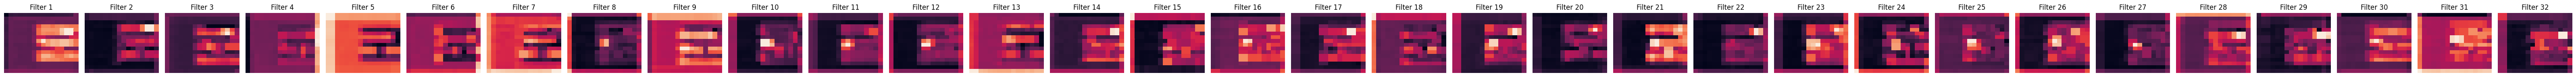

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the activations for the first item in the batch from the specified layer
activations_tensor = activations['max_pool2d'][0].cpu().numpy()

# Assuming the tensor is 4D, iterate over the filters/channels
num_filters = activations_tensor.shape[0]
fig, axes = plt.subplots(1, num_filters, figsize=(num_filters * 2, 2))

for i in range(num_filters):
    activation_map = activations_tensor[i, :, :]
    sns.heatmap(activation_map, ax=axes[i], cbar=False)
    axes[i].axis('off')  # Turn off the axis labels
    axes[i].set_title(f'Filter {i+1}')  # Set title to be the filter number

plt.tight_layout()
plt.show()


In [62]:
def get_model_layer_names(model):
    return [name for name, module in model.named_modules()]
names = get_model_layer_names(model)
print(names[:30])

['', 'conv_seqs', 'conv_seqs.0', 'conv_seqs.0.conv', 'conv_seqs.0.max_pool2d', 'conv_seqs.0.res_block0', 'conv_seqs.0.res_block0.conv0', 'conv_seqs.0.res_block0.conv1', 'conv_seqs.0.res_block1', 'conv_seqs.0.res_block1.conv0', 'conv_seqs.0.res_block1.conv1', 'conv_seqs.1', 'conv_seqs.1.conv', 'conv_seqs.1.max_pool2d', 'conv_seqs.1.res_block0', 'conv_seqs.1.res_block0.conv0', 'conv_seqs.1.res_block0.conv1', 'conv_seqs.1.res_block1', 'conv_seqs.1.res_block1.conv0', 'conv_seqs.1.res_block1.conv1', 'conv_seqs.2', 'conv_seqs.2.conv', 'conv_seqs.2.max_pool2d', 'conv_seqs.2.res_block0', 'conv_seqs.2.res_block0.conv0', 'conv_seqs.2.res_block0.conv1', 'conv_seqs.2.res_block1', 'conv_seqs.2.res_block1.conv0', 'conv_seqs.2.res_block1.conv1', 'hidden_fc']


In [25]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, shape: {param.size()}")

Parameter name: conv_seqs.0.conv.weight, shape: torch.Size([16, 3, 3, 3])
Parameter name: conv_seqs.0.conv.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.1.conv.weight, shape: torch.Size([32, 16, 3, 3])
Parameter name: conv_seqs.1.conv.bias, shape: torch.Size([32])
Parameter name: conv_seqs.1.res_block0.conv0.weight, shape: torch.Size([32, 3